In [13]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# random generator 
rng = np.random.default_rng(42)

In [14]:
# carregar dataset Iris (utilizando o UCI CSV)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data' 
cols = ['sepal_length','sepal_width','petal_length','petal_width','target_name']
df = pd.read_csv(url, header=None, names=cols)

# remover linhas vazias (caso hajam algumas)
df = df.dropna().reset_index(drop=True)


# map targets para inteiros 0,1,2
class_names = sorted(df['target_name'].unique())
target_map = {name:i for i,name in enumerate(class_names)}
df['y'] = df['target_name'].map(target_map)
X = df[cols[:-1]].values.astype(float)
y = df['y'].values.astype(int)
print('Loaded Iris: ', X.shape, 'examples, classes:', class_names)

Loaded Iris:  (150, 4) examples, classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


In [20]:
# funções auxiliares
def stratified_split_indices(y, test_size=0.3, random_state=None):
    rng = np.random.default_rng(random_state)
    train_idx = []
    test_idx = []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0].copy()
        rng.shuffle(idx)
        n_test = int(np.round(len(idx) * test_size))
        test_idx.extend(idx[:n_test])
        train_idx.extend(idx[n_test:])
    return np.array(train_idx, dtype=int), np.array(test_idx, dtype=int)

def knn_predict(X_train, y_train, X_test, k=3):

    # distance: (n_test, n_train)
    d = np.linalg.norm(X_test[:, None, :] - X_train[None, :, :], axis=2)
    nn = np.argsort(d, axis=1)[:, :k]  # indices of k nearest
    preds = []
    for i, neighbors in enumerate(nn):
        neigh_labels = y_train[neighbors]
        cnt = Counter(neigh_labels)
        # find classes with maximum votes
        max_votes = max(cnt.values())
        top_classes = [cls for cls, v in cnt.items() if v == max_votes]
        if len(top_classes) == 1:
            preds.append(top_classes[0])
            continue
        # empate: choose class of the nearest neighbor (smallest distance)
        distances = d[i, neighbors]
        # order neighbors by distance and pick first whose label is in top_classes
        order = np.argsort(distances)
        chosen = None
        for idx in order:
            lbl = neigh_labels[idx]
            if lbl in top_classes:
                chosen = lbl
                break
        preds.append(int(chosen))
    return np.array(preds, dtype=int)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_mat(y_true, y_pred, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    mat = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_idx = {l:i for i,l in enumerate(labels)}
    for t, p in zip(y_true, y_pred):
        mat[label_to_idx[t], label_to_idx[p]] += 1
    return mat, labels

def build_confusion_matrix(y_true, predictions):

    labels = {0: 0, 1: 1, 2: 2}

    cm = np.zeros((3, 3), dtype=int)
    
    for true_lbl, pred_lbl in zip(y_true, predictions):
        i = labels[true_lbl]
        j = labels[pred_lbl]
        cm[i, j] += 1
    
    return cm

def plot_confusion_matrix(cm):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(np.arange(3), ["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
    plt.yticks(np.arange(3), ["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
    plt.title("Confusion Matrix, without normalization")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    for i in range(3):
        for j in range(3):
            color = "white" if cm[i, j] > cm.max() / 2 else "black"
            plt.text(j, i, cm[i, j], ha="center", va="center", color=color)
    
    plt.tight_layout()
    plt.show()

def calcular_metricas(cm):

    precisions, recalls, f1s = [], [], []

    # Calcular métricas por classe
    for c in range(3):
        TP = cm[c, c]
        FP = cm[:, c].sum() - TP
        FN = cm[c, :].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    accuracy = np.trace(cm) / np.sum(cm)
    precision_macro = np.mean(precisions)
    recall_macro = np.mean(recalls)
    f1_macro = np.mean(f1s)

    return accuracy, precision_macro, recall_macro, f1_macro

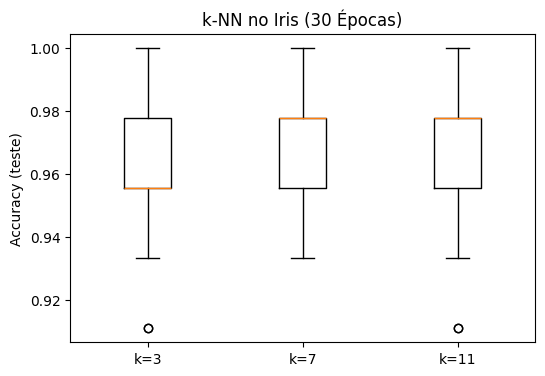

In [16]:
# 1) Partições estratificadas 70/30, 30 execuções (implementação própria)
n_splits = 30
test_size = 0.30
ks = [3, 7, 11]
accuracies = {k: [] for k in ks}
for i in range(n_splits):
    train_idx, test_idx = stratified_split_indices(y, test_size=test_size, random_state=42 + i)
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    for k in ks:
        y_pred = knn_predict(X_tr, y_tr, X_te, k=k)
        accuracies[k].append(accuracy(y_te, y_pred))

# Boxplot com whiskers
data = [accuracies[k] for k in ks]
plt.figure(figsize=(6,4))
plt.boxplot(data, tick_labels=[f'k={k}' for k in ks])
plt.ylabel('Accuracy (teste)')
plt.title('k-NN no Iris (30 Épocas)')
plt.show()

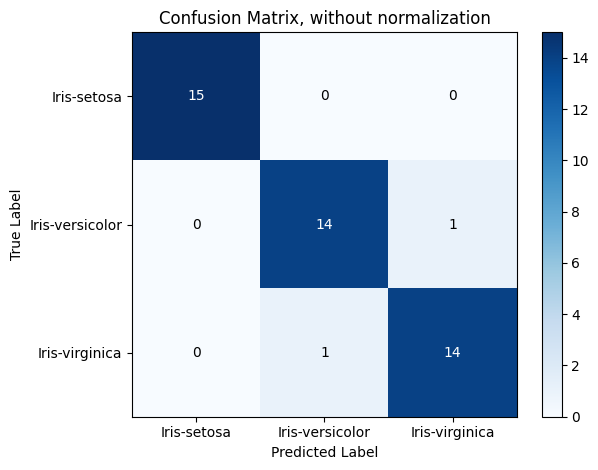

Accuracy: 0.9555555556
Precision: 0.9555555556
Recall: 0.9555555556
F1-Score: 0.9555555556


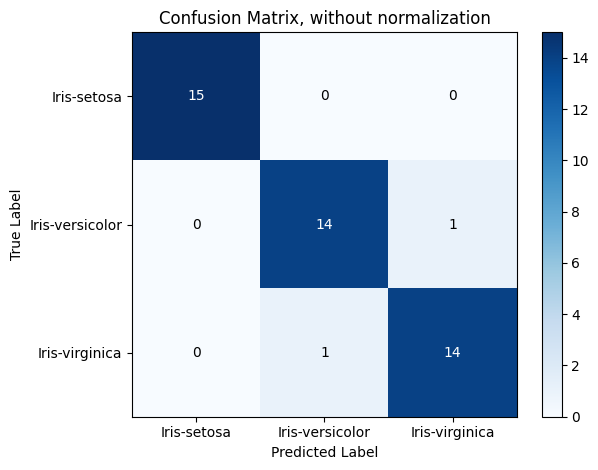

Accuracy: 0.9555555556
Precision: 0.9555555556
Recall: 0.9555555556
F1-Score: 0.9555555556


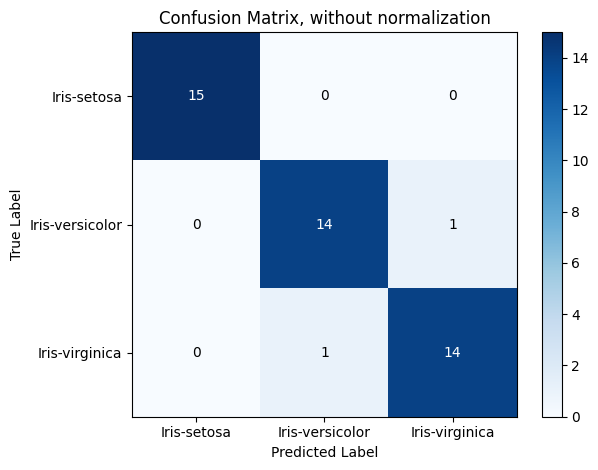

Accuracy: 0.9555555556
Precision: 0.9555555556
Recall: 0.9555555556
F1-Score: 0.9555555556


In [26]:
cm = None
accuracy = []

# 2) Uma única partição estratificada 70/30 e matrizes de confusão (implementação própria)
train_idx, test_idx = stratified_split_indices(y, test_size=0.30, random_state=7)
X_tr, X_te = X[train_idx], X[test_idx]
y_tr, y_te = y[train_idx], y[test_idx]

ks = [3, 7, 11]
for k in ks:
    y_pred = knn_predict(X_tr, y_tr, X_te, k=k)
    # cm, labels = confusion_mat(y_te, y_pred, labels=np.arange(len(class_names)))
    # df_cm = pd.DataFrame(cm, index=[f"true_{c}" for c in class_names], columns=[f"pred_{c}" for c in class_names])
    # print(f"\nMatriz de confusão — k={k}")
    # display(df_cm)

    a, p, r, f = calcular_metricas(build_confusion_matrix(y_te, y_pred.tolist()))

    cm = build_confusion_matrix(y_te, y_pred)

    #print(np.array(accuracy))

    plot_confusion_matrix(cm)

    print(f"Accuracy: {a:.10f}")           
    print(f"Precision: {p:.10f}")
    print(f"Recall: {r:.10f}")
    print(f"F1-Score: {f:.10f}")

### Exercício 2 — Alínea 3  
**Porque deve o valor de *k* ser ímpar (com base na Fig. 3)?**

No algoritmo *k*-NN, cada ponto desconhecido é classificado segundo a **classe mais frequente**
entre os *k* vizinhos mais próximos.

- Se **k for par**, pode acontecer um **empate** entre classes (por exemplo 1–1 ou 2–2 num problema binário).  
  Nesse caso, o classificador precisa de um critério artificial de desempate
  (aleatório, prioridade de classe, ordem dos dados, etc.), o que introduz instabilidade.

- Se **k for ímpar**, garante-se que **há sempre uma maioria clara** entre as duas classes,
evitando empates e tornando o processo de decisão determinístico.

 **Conclusão:**  
Escolher *k* ímpar (por exemplo 3, 5, 7, 11…) evita empates em problemas binários e reduz a probabilidade de empate em problemas multiclasse, tornando o *k*-NN mais estável e previsível.
